# 필수 라이브러리

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family = 'malgun gothic')
mpl.rc('axes', unicode_minus= False)
sns.set_style("darkgrid")
plt.rc("figure", figsize=(10, 8))

# 데이터 로딩과 데이터 탐색

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [4]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [6]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


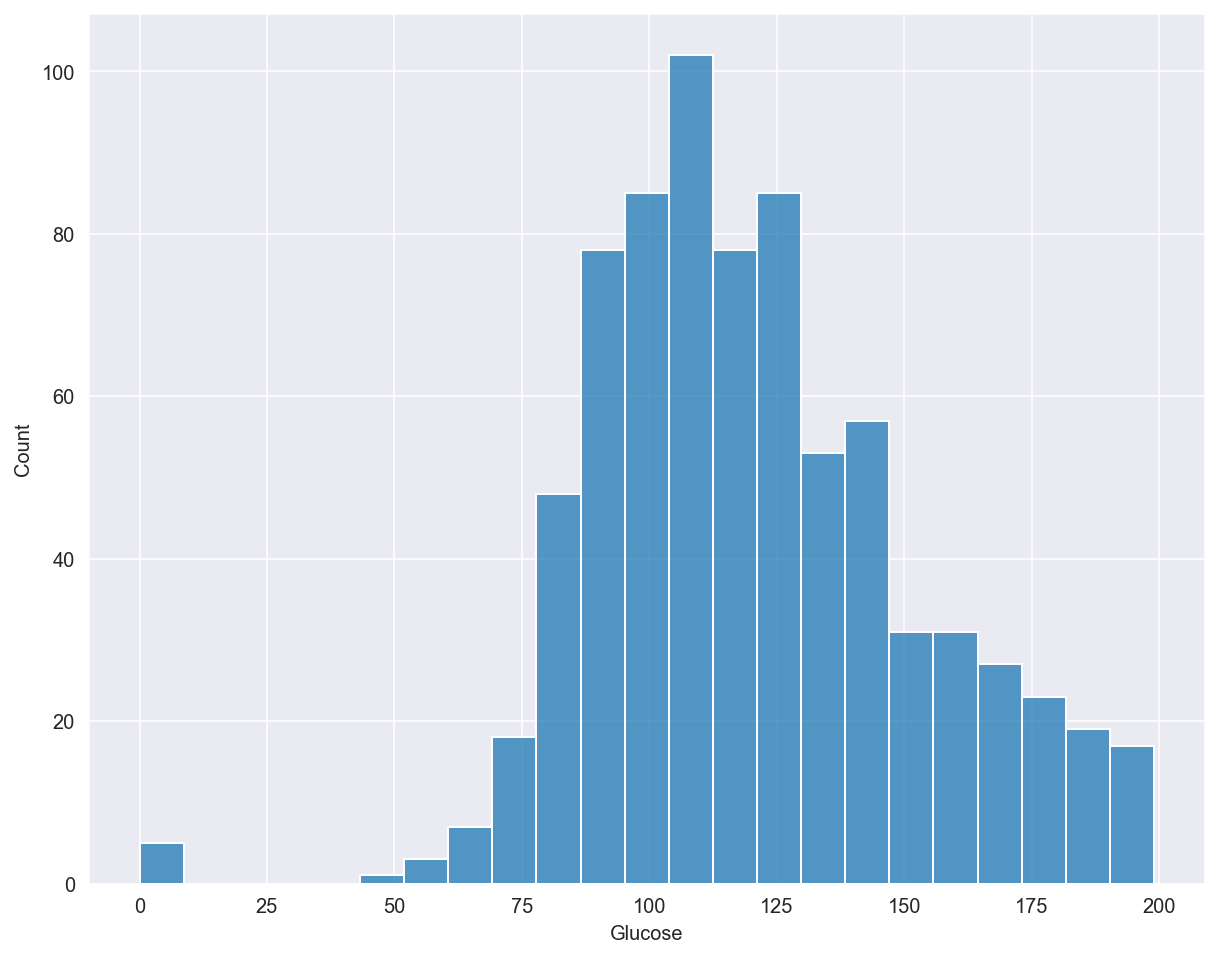

In [8]:
sns.histplot(data = diabetes, x='Glucose', kde=False)
plt.show()#

In [9]:
# 최소값은 0이많은데 하개씩 살펴봄

# 0값을 검사할 컬럼명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI']

# 0은 전체 데이터에 차지하는 비중

# 전체 데이터 건수
total_count = diabetes.count()[0]
total_count

# 각 feature별 0값이 차지하는 비율분석
for feature in zero_features :
    zero_count = diabetes[feature].value_counts()[0]
    zero_rate = zero_count / total_count * 100
    print(f'{feature}의 0건수 : {total_count}, 퍼센트 : {zero_rate:.2f}%')

Glucose의 0건수 : 768, 퍼센트 : 0.65%
BloodPressure의 0건수 : 768, 퍼센트 : 4.56%
SkinThickness의 0건수 : 768, 퍼센트 : 29.56%
Insulin의 0건수 : 768, 퍼센트 : 48.70%
BMI의 0건수 : 768, 퍼센트 : 1.43%


In [10]:
total_count

768

In [11]:
diabetes['Glucose'].value_counts()[0]

5

In [12]:
# SkinThickness, Insulin은 0값의 비율이 높아 데이터를 삭제하긴 무리가 있어 대체값이 필요함
mean_zero_features = diabetes[zero_features].mean()
diabetes[zero_features] = diabetes[zero_features].replace(0, mean_zero_features)

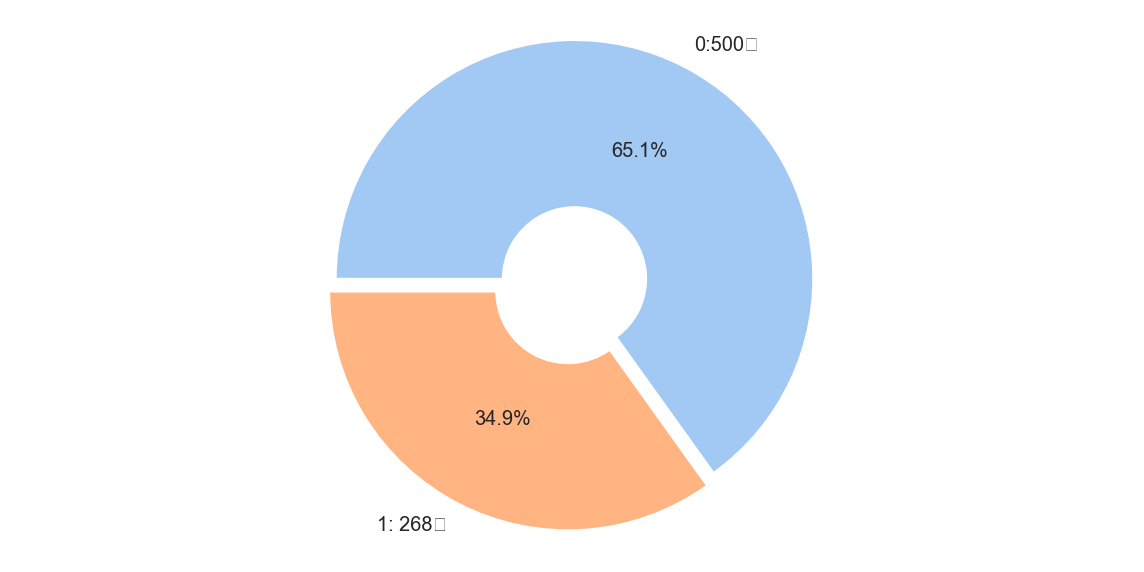

In [16]:
plt.figure(figsize=(10,5))

frequency = diabetes['Outcome'].value_counts()
label = [f"0:{frequency[0]}개", f"1: {frequency[1]}개"]

plt.pie(frequency,
       startangle = 180,
       counterclock = False,
       explode = [0.03] * 2,
       autopct = '%1.1f%%',
       labels = label,
       colors = sns.color_palette('pastel', 2),
       wedgeprops = dict(width=0.7))

plt.axis('equal')
plt.show()

In [17]:
# 재현율이 해야함

# 로지스틱 회귀 모델 구현

In [72]:
# 정규화

X = diabetes.iloc[:,:-1]
y = diabetes.Outcome

# StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

In [73]:
# 정밀도 TP / (TP + FP)
# 재현율 TP / (FN + TP)

## 학습 / 검증 데이터 분리

- **클래스별 비율에 맞게 분리**

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size = 0.2, stratify = y, random_state = 156)

# stratify 클래스의 비율에 맞게 분리

## Logistic Regreesion

### 혼돈 행렬(Confision Matrix, 오차행렬)

- TN : Negative값 0으로 예측했고  실제값도   Negative 0인 경우
- FP : Positive값 1로   예측했고  실젝값은   Negative값 0인 경우
- FN : Negative값 0으로 예측했고, 실제값은   Positive 1인 경우
- TP : Positive값 1로   예측했고, 실제값은   Positive 0인 경우
<br><br>
1. 정확도 : 전체 데이터개수 데비 정답을 맞춘 데이터의 개수
  - Accuracy = (TN + TP) / (TN + FP + FN + TP)
  
  
<br><br>
2. 정밀도와 민감도 : 비슷하지만 조금 다른 지표이며 불균이한 데이터셋을 다룰때 유용한 지표가 됨
  - 불균일한 데이터셋이란 데이터의 1과 0의 비율이 7:3 또는 3:7 이상 차이가 나는 상태를 의미한다
  - 정밀도(precision) : 학습한 모델이 1이라고 예측했을 떄 얼마나 잘 맞는지의 비율 **TP / (FP + TP)**
  - 민감도/재현율(recall) : 실제 1인 값을 모델이 얼마나 1로 잘 예측했는지에 대한 비율 **TP /(TP + FN)**


3. f1 score : 정밀도와 민감도를 통합한 지표로 정밀도와 민감도의 조화편균 값
  - 우리가 만든 모델이 얼마나 성능이 좋은지를 확인할 때 사용
  - 한 개의 지표(정밀도와 재현율중)를 정리할 필요가 있을 때 적합니다.
  - **2 * (precision * recall) / (precision + recall)**
<br><br>

- 이진분류 문제중 암에 걸렸는지 찾는 문제에서 진단이 암일 경우 1, 암이 아닌경우에 0
- 예 : 생존여부를 판단하는 문제에서 새존인 경우 1, 아닌 경우 0
- 우리가 알아내려는 값이 1이 된다.

In [129]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba= None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print('정확도 : {:.4f}, 정밀도 : {:.4f}, 재현율 : {:.4f}, F1 : {:.4f}, AUC : {:.4f}'.format(accuracy, precision,
                                                                                             recall, f1, roc_auc))


In [130]:
# 모델
lr = LogisticRegression()

# 학습
lr.fit(X_train, y_train)

# 예측
pred = lr.predict(X_test)
pred_proba_po = lr.predict_proba(X_test)[:,1].reshape(-1, 1)
pred_proba_po


cm = confusion_matrix(y_test, pred)
print(cm)


get_clf_eval(y_test, pred, pred_proba_po)

[[90 10]
 [21 33]]
오차행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1 : 0.6804, AUC : 0.8487


## 정밀도 / 재현율 시각화

In [136]:
# precisions, recalls, thresholds = precision_recall_curve(y_tst, pred_proba_po)

# 임계값 = 경계
# 재현율 60% 
# 임계값 올려
# 로지스틱 회귀에서 
# 임계값 올리면 1이 될 확율이 높아짐

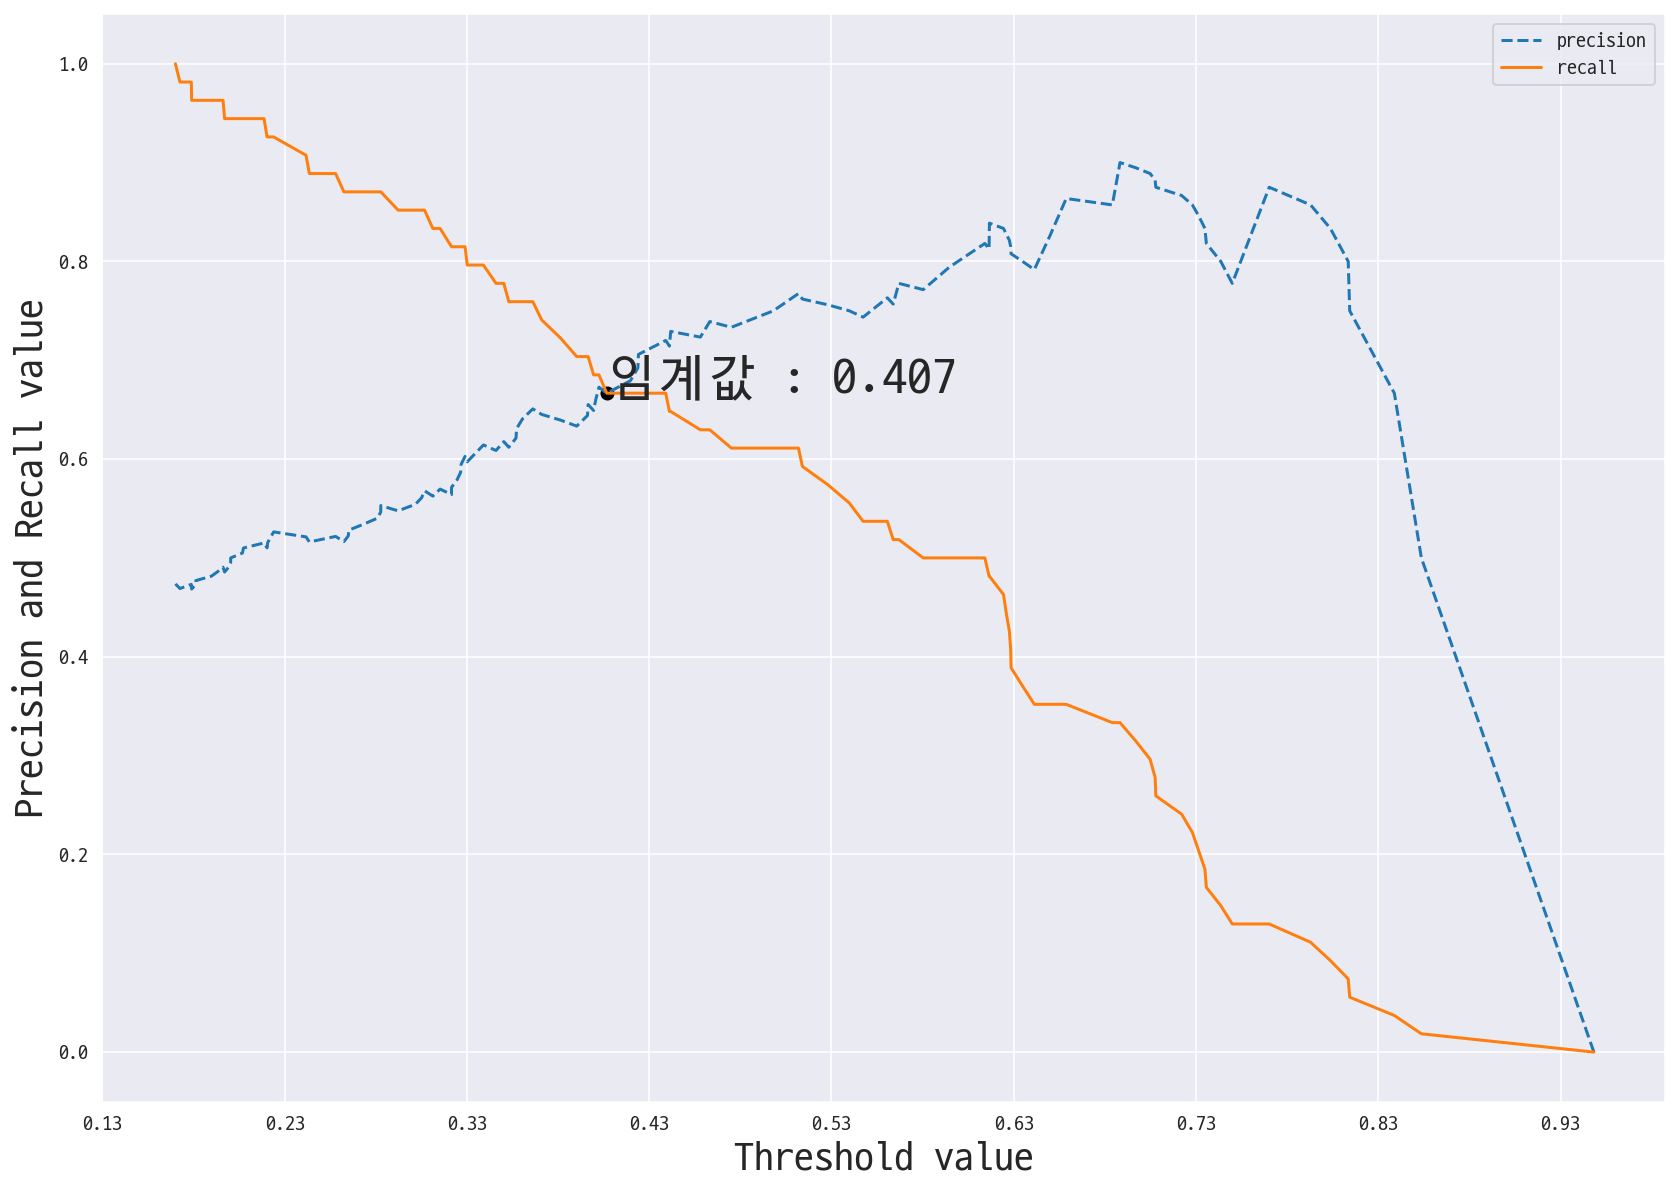

In [154]:
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_po)

# 재현율과 정밀도의 시각화
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize = (14, 10))
    plt.rc('font', family = 'D2coding')
    threshold_boundary = thresholds.shape[0]
    a = thresholds[precisions[0:threshold_boundary] == recalls[0:threshold_boundary]]
    loc = np.where(thresholds == a[0])[0][0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    plt.scatter(thresholds[loc], precisions[loc], c = 'black')
    plt.text(thresholds[loc], precisions[loc], '임계값 : {:.3f}'.format(thresholds[loc]), size = 25)
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlabel('Threshold value', size = 20); plt.ylabel('Precision and Recall value', size = 20)
    plt.legend()
    plt.rc('legend', fontsize = 20)
    plt.show()
    
# 정밀도, 재현율 시각화
precision_recall_curve_plot(y_test, pred_proba_po)

In [138]:
precision_recall_curve(y_test, pred_proba_po)

(array([0.47368421, 0.46902655, 0.47321429, 0.46846847, 0.47272727,
        0.47706422, 0.48148148, 0.48598131, 0.49056604, 0.48571429,
        0.49038462, 0.49514563, 0.5       , 0.5049505 , 0.51      ,
        0.51515152, 0.51020408, 0.51546392, 0.52083333, 0.52631579,
        0.5212766 , 0.51612903, 0.52173913, 0.51648352, 0.52222222,
        0.52808989, 0.53409091, 0.54022989, 0.54651163, 0.55294118,
        0.54761905, 0.55421687, 0.56097561, 0.56790123, 0.5625    ,
        0.56962025, 0.56410256, 0.57142857, 0.57894737, 0.58666667,
        0.59459459, 0.60273973, 0.59722222, 0.6056338 , 0.61428571,
        0.60869565, 0.61764706, 0.6119403 , 0.62121212, 0.63076923,
        0.640625  , 0.65079365, 0.64516129, 0.63934426, 0.63333333,
        0.6440678 , 0.65517241, 0.64912281, 0.66071429, 0.67272727,
        0.66666667, 0.67924528, 0.69230769, 0.70588235, 0.72      ,
        0.71428571, 0.72916667, 0.72340426, 0.73913043, 0.73333333,
        0.75      , 0.76744186, 0.76190476, 0.75

In [156]:
from sklearn.preprocessing import Binarizer

def get_clf_eval_thres(y_test, pred_po, threshold, f1_show=False, auc_show=False):
    eval_df = pd.DataFrame()
    
    for thres in threshold:
        # threshold에 따른 예측 분류 값
        binarizer = Binarizer(threshold = thres)
        binarizer.fit(pred_po)
        thres_pred = binarizer.transform(pred_po)
        
        # 평가지표  
        accuracy = accuracy_score(y_test, thres_pred)
        precision = precision_score(y_test, thres_pred)
        recall = recall_score(y_test, thres_pred)
        f1 = f1_score(y_test, thres_pred)
        auc = roc_auc_score(y_test, pred_po)
        
        # 데이터 프레임 형태
        eval_lst = np.array([accuracy, precision, recall, f1, auc]).reshape(-1,1)
        temp = pd.DataFrame(eval_lst, columns=[thres], 
                            index = ["정확도", "정밀도", "재현율", "F1스코어", "AUC"])
        eval_df = pd.concat([eval_df,temp], axis=1)
        
    eval_df.columns.names = ["임계값"]
    
    if f1_show == False:
        eval_df.drop("F1스코어", axis=0, inplace=True)
        
    if auc_show == False:
        eval_df.drop("AUC", axis=0, inplace=True)
        
    return round(eval_df, 4)

In [157]:
thres_lst = [0.3, 0,33, 0,36, 0,39, 0.42, 0.45, 0.48, 0.5]
get_clf_eval_thres(y_test, pred_proba_po, thres_lst, f1_show=True, auc_show=True)

임계값,0.30,0.00,33.00,0.00,36.00,0.00,39.00,0.42,0.45,0.48,0.50
정확도,0.7078,0.3506,0.6494,0.3506,0.6494,0.3506,0.6494,0.7792,0.7857,0.7922,0.7987
정밀도,0.5542,0.3506,0.0000,0.3506,0.0000,0.3506,0.0000,0.6923,0.7234,0.7500,0.7674
재현율,0.8519,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.6667,0.6296,0.6111,0.6111
F1스코어,0.6715,0.5192,0.0000,0.5192,0.0000,0.5192,0.0000,0.6792,0.6733,0.6735,0.6804
AUC,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487,0.8487


In [163]:
binarizer = Binarizer(threshold = 0.48)
pred048 = binarizer.fit_transform(pred_proba_po)
get_clf_eval(y_test, pred048, pred_proba_po)

오차행렬
[[89 11]
 [21 33]]
정확도 : 0.7922, 정밀도 : 0.7500, 재현율 : 0.6111, F1 : 0.6735, AUC : 0.8487
